In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from rom_am import POD, ROM, QUAD_MAN, DMDc, solid_ROM

In [23]:
tr_disp_data = []
tr_load_data = []
test_disp_data = []
test_load_data = []

cutoff = 425
end_incr = 750
num_of_params = 4
include_subiters = True

tr_first_iters = []
tr_converged_iters = [] 
flat_tr_converged_iters = [] 
flat_tr_first_iters = [] 

tst_first_iters = []
tst_converged_iters = []
flat_tst_converged_iters = [] 
flat_tst_first_iters = [] 

param_map = []
tst_param_map = []

folder_names = ["../Double_E10/10/", "../Double_E10/12/", "../Double_E10/14/"]
#folder_names = ["../Double_E10/14/", ]

num_of_params = len(folder_names)

j = 0
k = 0
l = 0
m = 0
n = 0
o = 0

for i in range(num_of_params):
    iters = np.load(folder_names[i]+"/coSimData/iters.npy")[:cutoff]
    iters[0] -= 1
    param_map.append(np.arange(0, iters.sum())+j)
    
    iters_tst = np.load(folder_names[i]+"/coSimData/iters.npy")[cutoff:end_incr]
    tst_param_map.append(np.arange(0, iters_tst.sum())+o)

    tr_first_iters.append(np.append(0, iters[:-1].cumsum().astype(int)))
    tr_converged_iters.append((iters.cumsum()-1).astype(int))
    flat_tr_converged_iters.append(tr_converged_iters[-1]+ k)
    flat_tr_first_iters.append(tr_first_iters[-1]+ l)

    tst_first_iters.append(np.append(0, iters_tst[:-1].cumsum().astype(int)))
    tst_converged_iters.append((iters_tst.cumsum()-1).astype(int))
    flat_tst_converged_iters.append(tst_converged_iters[-1]+ m)
    flat_tst_first_iters.append(tst_first_iters[-1]+ n)
    
    if include_subiters:
        tr_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, :tr_converged_iters[-1][-1]+1])
        tr_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, :tr_converged_iters[-1][-1]+1])

        test_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tr_converged_iters[-1][-1]+1:
                                                                                  tst_converged_iters[-1][-1]+1+tr_converged_iters[-1][-1]+1])
        test_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tr_converged_iters[-1][-1]+1:
                                                                                  tst_converged_iters[-1][-1]+1+tr_converged_iters[-1][-1]+1])

    else:            
        tr_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tr_converged_iters[-1]])
        tr_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tr_converged_iters[-1]])
        
        test_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tst_converged_iters[-1]])
        test_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tst_converged_iters[-1]])
        
    j += iters.sum()
    o += iters_tst.sum()
    k += tr_converged_iters[-1][-1]
    l += tr_first_iters[-1][-1]
    m += tst_converged_iters[-1][-1]
    n += tst_first_iters[-1][-1]

tr_disp_data = np.concatenate(tr_disp_data, axis=1)
tr_load_data = np.concatenate(tr_load_data, axis = 1)
test_disp_data = np.concatenate(test_disp_data, axis=1)
test_load_data = np.concatenate(test_load_data, axis = 1)
flat_tr_converged_iters = np.concatenate((flat_tr_converged_iters))

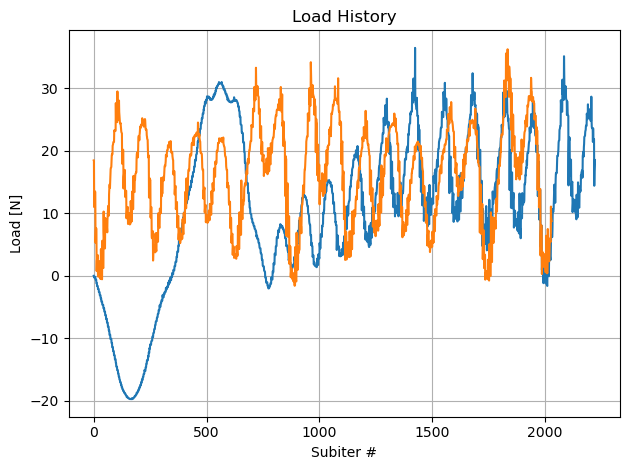

In [24]:
if include_subiters:
    plt.plot(tr_load_data[20, :]);
    plt.plot(test_load_data[20, :]);
    plt.xlabel("Subiter #");
else:
    plt.plot(np.arange(0., num_of_params*cutoff), tr_load_data[20, :]);
    plt.plot(np.arange(num_of_params*cutoff, num_of_params*end_incr), test_load_data[20, :]);
    plt.xlabel("Increment #");

plt.ylabel("Load [N]");
plt.title("Load History");

plt.grid();
plt.tight_layout();

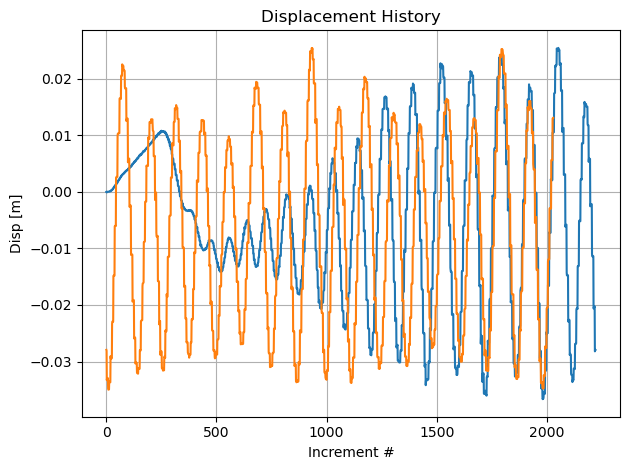

In [25]:
if include_subiters:
    plt.plot(tr_disp_data[20, :]);
    plt.plot(test_disp_data[20, :]);
    plt.xlabel("Subiter #");
else:
    plt.plot(np.arange(0., num_of_params*cutoff), tr_disp_data[20, :]);
    plt.plot(np.arange(num_of_params*cutoff, num_of_params*end_incr), test_disp_data[20, :]);
    plt.xlabel("Increment #");
    
plt.xlabel("Increment #");
plt.ylabel("Disp [m]");
plt.title("Displacement History");

plt.grid();
plt.tight_layout();

In [59]:
rom_model = solid_ROM()
rom_model.train(tr_load_data, tr_disp_data, rank_pres=.9999, rank_disp=.9999, degree = 3, ridge=True,  
                separate=False, norm_regr=True, ids=None,
                quad_=True, clustering=False, alpha=1e-4, map_used = np.load("../coSimData/map_used.npy").T)

Reconstruction error linear basis:  0.0029748768254498634
Reconstruction error quadratic manifold:  0.0011948937058621804


In [8]:
rom_model.store_last_result()

In [7]:
predicted_disp = rom_model.pred(test_load_data)

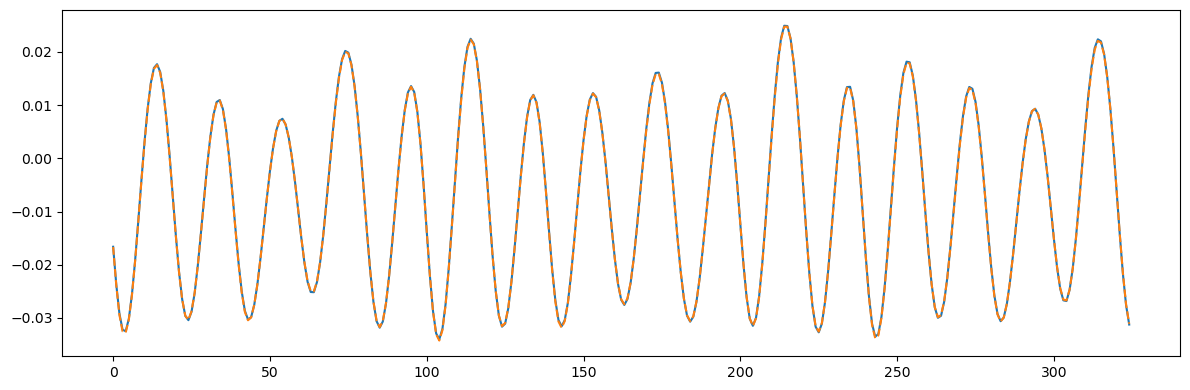

In [11]:
fig = plt.figure(figsize = (12, 4));
plt.plot(test_disp_data[:, tst_param_map[0]][300, tst_converged_iters[0]]);
plt.plot(predicted_disp[:, tst_param_map[0]][300, tst_converged_iters[0]], '--');
plt.tight_layout()

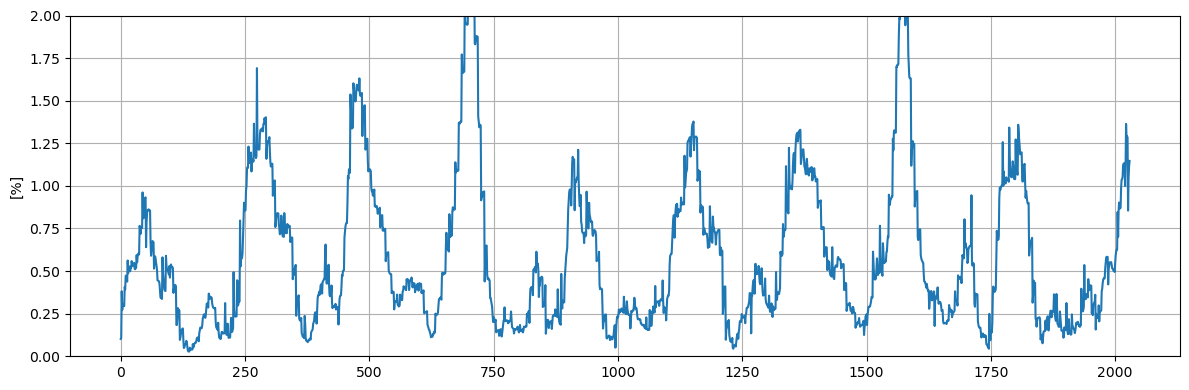

In [87]:
fig = plt.figure(figsize = (12, 4));
abs_err = np.linalg.norm(test_disp_data - predicted_disp, axis = 0)
rel_err = abs_err / np.linalg.norm(test_disp_data, axis = 0)
plt.plot(100 * rel_err,);
plt.ylabel("[%]");
plt.ylim(top=2., bottom = 0.);
plt.tight_layout();
plt.grid();

In [29]:
"""
import pickle

with open('Double_ROM_models/sol_rom_Double_E_10_one_14_MAP_99.pkl', 'wb') as outp:
    pickle.dump(rom_model, outp, pickle.HIGHEST_PROTOCOL)
""";

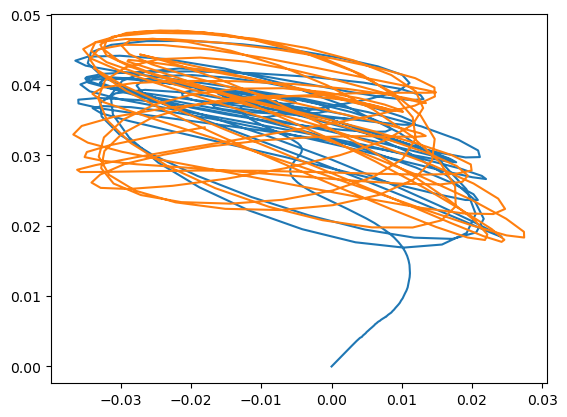

In [ ]:
plt.plot(tr_disp_data[546, flat_tr_converged_iters], 
         tr_disp_data[2976, flat_tr_converged_iters]);
plt.plot(test_disp_data[546, flat_tst_converged_iters[0]], 
         test_disp_data[2976, flat_tst_converged_iters[0]]);

In [ ]:
import sklearn
from sklearn.cluster import KMeans

X = np.vstack((tr_disp_data[[546], :], tr_disp_data[[2976], :])).T
X = X[700:, :]
mean_X = X.mean(axis = 0)[np.newaxis, :]
X -= mean_X
kmeans = KMeans(n_clusters=4, random_state=0, n_init='auto', tol = 1e-7)
kmeans.fit(X)



KMeans(n_clusters=4, n_init='auto', random_state=0, tol=1e-07)

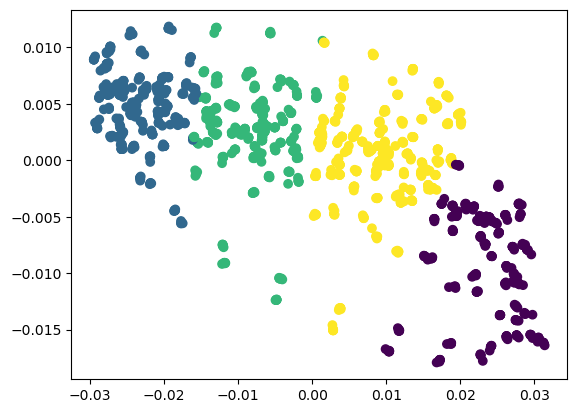

In [48]:
#X = np.vstack((tr_disp_data[[546], :], tr_disp_data[[2976], :])).T
#X -= mean_X
pred_dt = X.copy()
labels = kmeans.predict(pred_dt)
plt.scatter(pred_dt[:, 0], pred_dt[:, 1], c = labels);